In [ ]:
import numpy as np
import torch
import sys
sys.path.append('./code')
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.vgg import vgg19
from utils import *

In [ ]:
import cv2

In [ ]:
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from cv2.ximgproc import guidedFilter
from PIL import Image

In [ ]:
from typing import List

In [ ]:
from typing import List
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from cv2.ximgproc import guidedFilter
from PIL import Image

# fushion stragety


def low_pass(img, k=(30, 30)):
    'img: np.ndarray, float32, 0-1'
    assert img.dtype == np.float32 and img.max() <= 1., \
        'img must be in np.float32 for utils.low_pass'
    base = cv2.blur(img, k)
    detail = img - base
    return base, detail


def decompose(float_imgs):
    bases, details = [], []
    for fimg in float_imgs:
        base, detail = low_pass(fimg)
        bases.append(base)
        details.append(detail)
    return bases, details


def saliency(img, D):
    assert img.dtype == np.uint8, 'img must be in np.uint8 for utils.saliency'
    hist = np.bincount(img.flatten(), minlength=256) / img.size
    sal_values = np.dot(hist, D)
    saliency = sal_values[img]
    return saliency


def sal_weights(imgs):
    D = cdist(np.arange(256).reshape(-1, 1), np.arange(256).reshape(-1, 1))
    Ws = [saliency(img, D) for img in imgs]
    Ws = np.dstack(Ws) + 1e-12
    Ws = Ws / Ws.sum(axis=2, keepdims=True)
    return Ws


def guided_optimize(guides, srcs, r, eps):
    Ws = [guidedFilter(guide.astype(np.float32), src.astype(np.float32), r, eps)
          for guide, src in zip(guides, srcs)]
    Ws = np.dstack(Ws) + 1e-12
    Ws = Ws / Ws.sum(axis=2, keepdims=True)
    return Ws


def weighted_sum(imgs, ws):
    return np.sum(ws * np.dstack(imgs), axis=2)


def cnn_detail_fusion(inp, model, device, relus):
    'inp: [K, 3, H, W], torch.tensor'
    model.to(device)
    model.eval()

    inp = inp.to(device)
    out = inp
    Wls = []  # upsampled L-1 feature map at each layer
    with torch.no_grad():
        for i in range(max(relus) + 1):
            out = model.features[i](out)
            if i in relus:
                l1_feat = (F.interpolate(out, inp.shape[-2:])  # upsampled activation
                            .norm(1, dim=1, keepdim=True))    # L-1 norm along channel dim
                w_l = F.softmax(l1_feat, dim=0)
                Wls.append(w_l)

    saliency_max = -np.inf * torch.ones((3,) + inp.shape[-2:])
    saliency_max = saliency_max.to(device)
    for w_l in Wls:
        saliency_curr = (inp * w_l).sum(0)
        saliency_max = torch.max(saliency_max, saliency_curr)

    fused_detail = saliency_max
    return to_numpy(fused_detail[0])


def split_YCbCr(imgs):
    Y, Y_f, CbCr_f = [None] * len(imgs), [None] * len(imgs), [None] * len(imgs)
    for i, img in enumerate(imgs):
        if is_gray(img):
            Y[i] = img
        else:
            YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            Y[i] = YCrCb[:, :, 0]
            CbCr_f[i] = (YCrCb[:, :, 1:] / 255.).astype(np.float32)
        Y_f[i] = (Y[i] / 255.).astype(np.float32)
    return Y, Y_f, CbCr_f


def YCbCr_to_RGB(CbCrs, fusedY):
    fused = fusedY
    for cbcr in CbCrs:
        if cbcr is not None:
            fused = np.dstack((fusedY, cbcr))
            fused = cv2.cvtColor(fused, cv2.COLOR_YCrCb2RGB)
            fused = np.clip(fused, 0, 1)
    return fused


# numpy and torch converter
def to_tensor(a):
    if a.ndim == 2:
        a = np.expand_dims(a, (0, 1))
    if a.ndim == 3:
        a = np.expand_dims(np.moveaxis(a, -1, 0), 0)
    return torch.from_numpy(a)


def to_numpy(t):
    a = t.squeeze().detach().cpu().numpy()
    if a.ndim == 3:
        np.moveaxis(a, 0, -1)
    return a


def stack_to_tensor(imgs: List[np.ndarray]):
    tmp = []
    for img in imgs:
        if img.dtype == np.uint8:
            img = (img / 255.).astype(np.float32)
        if img.ndim == 2:
            img = np.expand_dims(img, (0, 1))
            tmp.append(np.repeat(img, 3, axis=1))
        # if img.ndim == 3:
        #     img = np.moveaxis(img, -1, 0)
        #     tmp.append(np.expand_dims(img, 0))
    return torch.from_numpy(np.vstack(tmp))


# image

def read_image(image_path):
    img = cv2.imread(str(image_path), -1)
    if img is None:
        raise FileNotFoundError(f'cv2 read {str(image_path)} failed')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def save_image(img: np.ndarray, savePath):
    if img.dtype == np.float32:
        assert img.max() <= 1 and img.min() >= 0, f'image of dtype np.float32 should range in 0-1'
        img = np.rint(img * 255).astype(np.uint8)
    Image.fromarray(img).save(savePath)


def is_gray(img: np.ndarray):
    assert len(img.shape) <= 3, 'Wrong np.ndarray image shape in func utils.is_gray'
    if img.ndim == 2 or img.shape[2] == 1:
        return True
    return False


def _c3(img):
    if img.ndim == 2:
        img = np.dstack((img, img, img))
    return img


def putText(img, text):
    pos = (15, 25)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    img = cv2.putText(img, text, pos, font, 0.8, color, 2)
    return img


_TON_IMSIZE = (360, 270)


def grid_row(*imgs, resized=_TON_IMSIZE):
    row = []
    for img in imgs:
        row.append(cv2.resize(img, resized, interpolation=cv2.INTER_CUBIC))
    return row


def make_grid(nested_list, resized=_TON_IMSIZE, addText=False, hsep=7, wsep=7):
    m, n = len(nested_list), len(nested_list[0])
    w, h = resized

    gH = m * h + (m - 1) * hsep
    gW = n * w + (n - 1) * wsep

    grid = (np.ones((gH, gW, 3)) * 255).astype(np.uint8)
    for i in range(m):
        y = (h + hsep) * i
        for j in range(n):
            x = (w + wsep) * j
            this = _c3(nested_list[i][j])
            if addText:
                text = f'Input-{j+1}' if j < n - 1 else 'Fused'
                this = putText(this, text)
            grid[y:y + h, x:x + w] = this

    return grid


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def imread(image, mode):
    return np.array(Image.open(image).convert(mode))
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
model = vgg19(pretrained=True)
vgg19_relus = [1, 3, 8]

path_to_images = ['/content/gdrive/MyDrive/acv.png', '/content/gdrive/MyDrive/a.png']
imgs = [imread(p, mode='L') for p in path_to_images]

float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
def weighted_sum(imgs, ws):
    return np.sum(ws * np.dstack(imgs), axis=2)

def guided_optimize(guides, srcs, r, eps):
    Ws = [guidedFilter(guide.astype(np.float32), src.astype(np.float32), r, eps)
          for guide, src in zip(guides, srcs)]
    Ws = np.dstack(Ws) + 1e-12
    Ws = Ws / Ws.sum(axis=2, keepdims=True)
    return Ws
def saliency(img, D):
    assert img.dtype == np.uint8, 'img must be in np.uint8 for utils.saliency'
    hist = np.bincount(img.flatten(), minlength=256) / img.size
    sal_values = np.dot(hist, D)
    saliency = sal_values[img]
    return saliency
def sal_weights(imgs):
    D = cdist(np.arange(256).reshape(-1, 1), np.arange(256).reshape(-1, 1))
    Ws = [saliency(img, D) for img in imgs]
    Ws = np.dstack(Ws) + 1e-12
    Ws = Ws / Ws.sum(axis=2, keepdims=True)
    return Ws

def low_pass(img, k=(30, 30)):
    'img: np.ndarray, float32, 0-1'
    assert img.dtype == np.float32 and img.max() <= 1., \
        'img must be in np.float32 for utils.low_pass'
    base = cv2.blur(img, k)
    detail = img - base
    return base, detail
def decompose(float_imgs):
    bases, details = [], []
    for fimg in float_imgs:
        base, detail = low_pass(fimg)
        bases.append(base)
        details.append(detail)
    return bases, details

bases, details = decompose(float_imgs)

Wb_0 = sal_weights(imgs)
Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

fused_base = weighted_sum(bases, Wb)

tc_details = stack_to_tensor(details)
fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

fused = np.clip(fused_base + fused_detial, 0, 1)
fused = np.rint(fused * 255).astype(np.uint8)


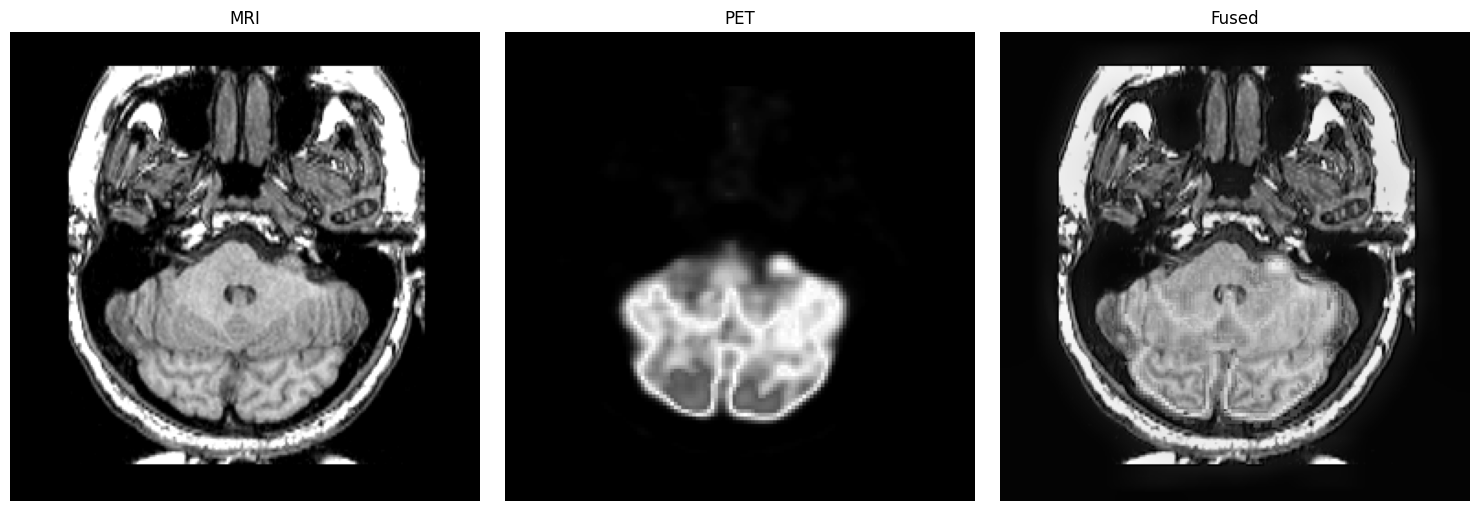

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(imgs[0], cmap='gray')
axes[0].set_title('MRI')
axes[1].imshow(imgs[1], cmap='gray')
axes[1].set_title('PET')
axes[2].imshow(fused, cmap='gray')
axes[2].set_title('Fused')
for ax in axes:
    ax.axis('off')
fig.tight_layout()

In [ ]:
fig.savefig('/content/gdrive/MyDrive/IV_01_fused.png')

## More resuts demo
The images below were collect from [the Whole Brain Atlas](http://www.med.harvard.edu/AANLIB/home.html)   
And can be reproduced via `/code/main.py`

In [ ]:
from wand.image import Image as WImage
img = WImage(filename='results/MRI-SPECT/combined.pdf')
img

ModuleNotFoundError: ignored

In [ ]:
import sys
import pkg_resources
import argparse
from pathlib import Path
from subprocess import check_call

import torch
from torchvision.models.vgg import vgg19

from skimage.measure import shannon_entropy
from pytorch_msssim import SSIM, MS_SSIM

from utils import *
from metrics import *

In [ ]:
pip install metrics

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.7/841.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17795 sha256=f0de1ad2817ee702db1c6e71e5e0016df3963b0d44d9ccfd367c565d28288d43
  Stored in directory: /root/.cache/pip/wheels/29/7a/e7/1175d9ff10607b8f02aa37c32392cb28cdda0aea8fcc2b514b
  Created wheel for pathspec: filename=pathspec-0.5.5-py3-none-any.whl size=24219 sha256=60c3354bddc3e6c0e1c0f31af169c1276d8dc715cb5ea1915773948778a17acc
  Stored in directory: /root/.cache/pip/wheels/28/d4/11/01ccd690e97b06874998aa554a8b2610c361900d2a7e038300
Successfully built metrics pathspec
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.14.0
    Uninstalling Pygments-2.14.0:
      Successfully uninstalled Pygments-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [ ]:



def parse_args():
    '''Usage:
        python main.py --imagePath=../images/IV_images --imageSource "VIS*.png" "IR*.png"
        python main.py --imagePath=../images/MRI-PET --imageSource "MRI*.png" "PET*.png"
        # python main.py --imagePath=../images/MRI-SPECT --imageSource "MRI*.png" "SPECT*.png"
    '''
    parser = argparse.ArgumentParser(description='Image Fusion with guided filter and vgg19')
    parser.add_argument('--imagePath', required=True)
    parser.add_argument('--imageSources', required=True, nargs='+')
    args = parser.parse_args()
    return args


class Args:
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    k = (30, 30)  # box blur kernel size
    r, eps = 45, 0.01  # parameters for guided filter

    model = vgg19(pretrained=True)
    relus = [1, 3, 8]  # relus for vgg19

    args = parse_args()

    imagePath = Path(args.imagePath)
    # put images needed to be fused together in a bundle
    imageSources = []
    for pattern in args.imageSources:
        imageSources.append(sorted(imagePath.glob(pattern)))
    bundles = zip(*imageSources)

    # grid_cell_size = (360, 270)  # for IV_images
    grid_cell_size = (320, 320)  # for brain MRI/CT images
    resultPath = Path('../results').joinpath(imagePath.stem)

    # install package
    _installed = {pkg.key for pkg in pkg_resources.working_set}
    if 'pytorch-msssim' not in _installed:
        _python = sys.executable
        check_call(['echo', '[INFO] Install pytorch-msssim'])
        _pipinstall = ['sudo', _python, '-m', 'pip', 'install', 'pytorch-msssim']
        check_call(_pipinstall)


if __name__ == '__main__':
    container = dict(SCD=[], SSIM_f=[], MSSSIM_f=[], Qmi=[], EN=[], MI=[])
    ssim_measure = SSIM(data_range=1.0, size_average=True, channel=1)
    msssim_measure = MS_SSIM(data_range=1.0, size_average=True, channel=1)

    nested_list = []
    Args.resultPath.mkdir(parents=True, exist_ok=True)

    for bundle in Args.bundles:
        print(f'Fusing => f{[fp.name for fp in bundle]}')
        imgs = [read_image(fp) for fp in bundle]  # np.uint8

        Ys, Ys_f, CbCrs_f = split_YCbCr(imgs)

        bases, details = decompose(Ys_f)

        Wb_0 = sal_weights(Ys)
        Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
        Wb = guided_optimize(Ys_f, Wb_0, Args.r, Args.eps)

        fused_base = weighted_sum(bases, Wb)

        tensor_details = stack_to_tensor(details)
        fused_detial = cnn_detail_fusion(
            tensor_details, Args.model, Args.device, relus=Args.relus)

        fusedY_f = np.clip(fused_base + fused_detial, 0, 1)

        fused_f = YCbCr_to_RGB(CbCrs_f, fusedY_f)

        fused_u8 = np.rint(fused_f * 255).astype(np.uint8)
        name = ''.join(x for x in bundle[0].name if x.isdigit())
        save_image(fused_u8, Args.resultPath.joinpath(f'FUSED-{name}.png'))

        nested_list.append(grid_row(*imgs, fused_u8, resized=Args.grid_cell_size))

        if len([x for x in CbCrs_f if x is not None]) == 0:
            print('Evaluation..')
            container['SCD'].append(SCD(Ys_f[0], Ys_f[1], fused_f))
            container['SSIM_f'].append(
                ssim_f(to_tensor(Ys_f[0]),
                       to_tensor(Ys_f[1]), to_tensor(fused_f), measure=ssim_measure)
            )
            container['MSSSIM_f'].append(
                ssim_f(to_tensor(Ys_f[0]),
                       to_tensor(Ys_f[1]), to_tensor(fused_f), measure=msssim_measure)
            )
            container['Qmi'].append(Qmi(Ys_f[0], Ys_f[1], fused_f))
            container['EN'].append(shannon_entropy(fused_u8))
            container['MI'].append(mi_f(Ys_f[0], Ys_f[1], fused_f))

            for k, v in container.items():
                print(f'{k} : {np.mean(v):.4f}')

            print('Done!\n')

    grid = make_grid(nested_list, Args.grid_cell_size, addText=True)
    save_image(grid, Args.resultPath.joinpath('combined.pdf'))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
usage: ipykernel_launcher.py [-h] --imagePath IMAGEPATH --imageSources
                             IMAGESOURCES [IMAGESOURCES ...]
ipykernel_launcher.py: error: the following arguments are required: --imagePath, --imageSources


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
